## Annotated code for kaggle.com competition "House Prices: Advanced Regression Techniques"

General setup and loading the provided train and test datasets into their own dataframes:

In [170]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', 100)

train = pd.read_csv('kaggle_data/housing_prices/train.csv')
test = pd.read_csv('kaggle_data/housing_prices/test.csv')

## sample data
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Look for any obvious outliers, since some regression models are particularly sensitive to them.  Sale price vs. above grade living area is a reasonable starting point.

<IPython.core.display.Javascript object>


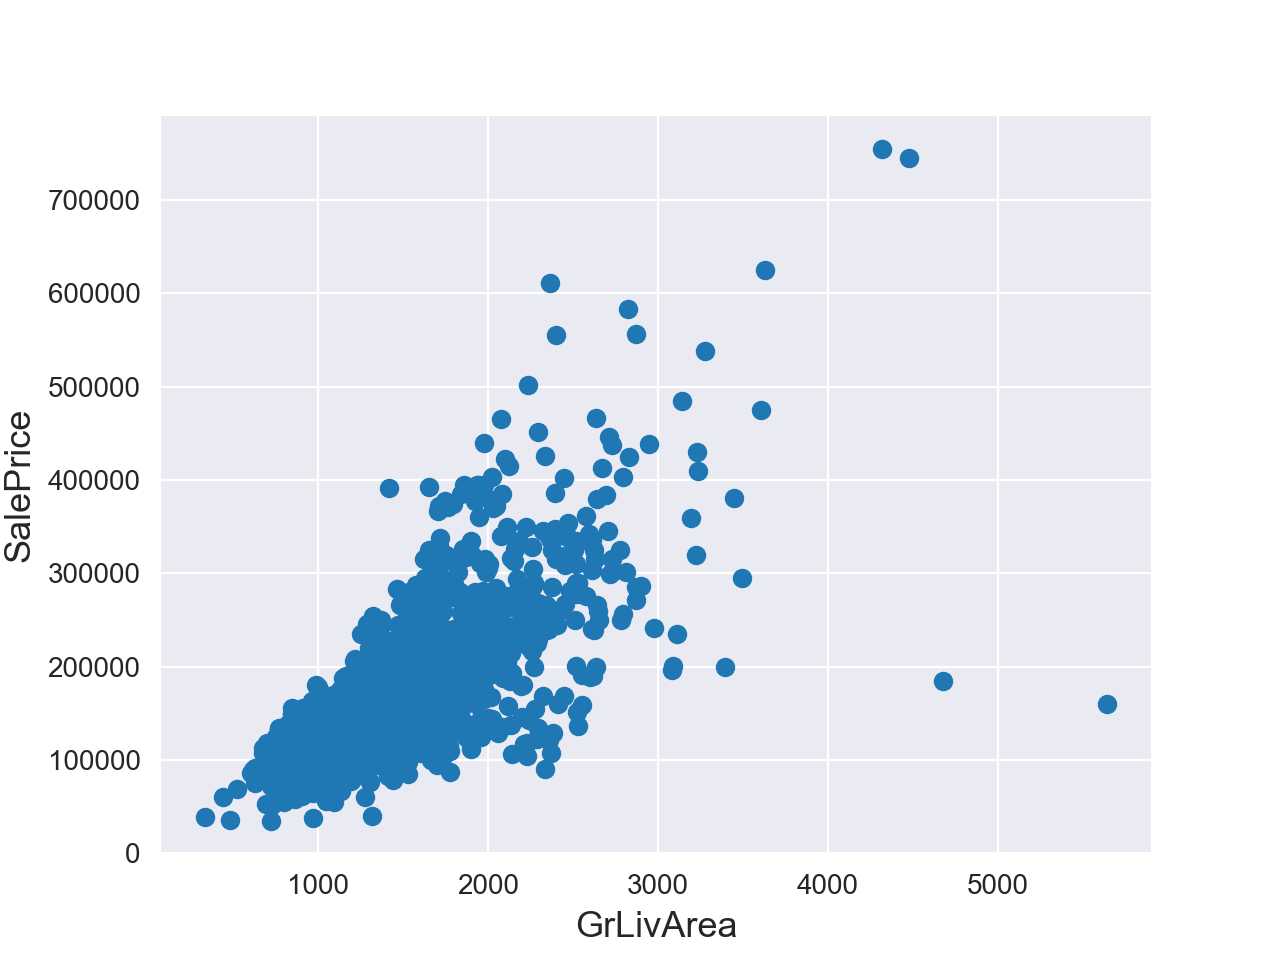

In [93]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

Very large living area and (relatively) low price can be safely considered an outlier, so we'll go ahead and get rid of those.  We don't want to be too aggressive on removing outliers in case we negatively influence the model performance, so we'll start with just that:

In [94]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

Set up several different models to see how they perform out of the box:

In [105]:
def linear(X_train, X_test, y_train, y_test):
    from sklearn.linear_model import LinearRegression
    
    lr = LinearRegression().fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    accuracy = lr.score(X_test, y_test)
    
    return accuracy

In [88]:
def dtree(X_train, X_test, y_train, y_test):
    from sklearn.tree import DecisionTreeRegressor
    
    dtr = DecisionTreeRegressor(random_state=0).fit(X_train, y_train)
    y_pred = dtr.predict(X_test)
    accuracy = dtr.score(X_test, y_test)
    
    return accuracy

In [90]:
def forest(X_train, X_test, y_train, y_test):
    from sklearn.ensemble import RandomForestRegressor
    
    rfr = RandomForestRegressor(random_state=0).fit(X_train, y_train)
    y_pred = rfr.predict(X_test)
    accuracy = rfr.score(X_test, y_test)
        
    return accuracy, rfr.feature_importances_

In [91]:
def elasticnetcv(X_train, X_test, y_train, y_test):
    from sklearn.linear_model import ElasticNetCV
 
    elastic = ElasticNetCV(random_state=0).fit(X_train, y_train)
    y_pred = elastic.predict(X_test)
    accuracy = elastic.score(X_test, y_test)
    
    return accuracy

In [156]:
def gradboostr(X_train, X_test, y_train, y_test):
    from sklearn.ensemble import GradientBoostingRegressor
    
    gbr = GradientBoostingRegressor(loss='huber', random_state=0).fit(X_train, y_train)
    y_pred = gbr.predict(X_test)
    accuracy = gbr.score(X_test, y_test)
    
    return accuracy, gbr.feature_importances_

Now we do a list bit of feature engineering and start evaluating models:

In [111]:
## last column is SalePrice, i.e., our label target
X = train.iloc[:,:-1]
y = train.iloc[:,-1]

## check any numeric columns that are missing values; it's possible that some non-numeric columns
## will influence the model, but this is a reasonable first step
#print(X[X.columns[X.isna().any()]].select_dtypes(include=np.number).head())

## reasonable to assume that lot frontage is probably roughly equivalent across each neighborhood, so
## fill in missing values with the median LotFrontage of the neighborhood -- idea from user Serigne on kaggle
X['LotFrontage'] = X.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

## set unknown values for both of these to 0, because by implication the features they reference don't exist
## in the property
X['MasVnrArea'] = X['MasVnrArea'].fillna(value=0)
X['GarageYrBlt'] = X['GarageYrBlt'].fillna(value=0)

X = X.select_dtypes(include=np.number)

X_train, X_test, y_train, y_test = train_test_split(X, y)

lr_acc = linear(X_train, X_test, y_train, y_test)
print('linreg accuracy {}'.format(lr_acc))

dtree_acc = dtree(X_train, X_test, y_train, y_test)
print('decision tree accuracy {}'.format(dtree_acc))

forest_acc, _ = forest(X_train, X_test, y_train, y_test)
print('random forest accuracy {}'.format(forest_acc))

elastic_acc = elasticnetcv(X_train, X_test, y_train, y_test)
print('elasticnetcv accuracy {}'.format(elastic_acc))

gbr_acc, _ = gradboostr(X_train, X_test, y_train, y_test)
print('gradient boost accuracy {}'.format(gbr_acc))

linreg accuracy 0.8605600775878677
decision tree accuracy 0.7909448992579385
random forest accuracy 0.8900723654471099
elasticnetcv accuracy 0.6907335022945897
gradient boost accuracy 0.90129318945445


Based on these numbers, the gradient boosted regressor has a slight edge.  Let's focus on that one and try to improve performance by tweaking the feature matrix.

In [112]:
_, features = gradboostr(X_train, X_test, y_train, y_test)

feat_combined = dict(zip(X_train.columns.tolist(), features))
feat_sorted = {k: v for k, v in sorted(feat_combined.items(), key=lambda item: item[1], reverse=True)}

print(feat_sorted.items())

dict_items([('OverallQual', 0.5284002123045008), ('GrLivArea', 0.14485359137770643), ('TotalBsmtSF', 0.0678993587393144), ('YearBuilt', 0.05462132129412252), ('BsmtFinSF1', 0.03693137177414998), ('GarageCars', 0.03255844621839817), ('LotArea', 0.025586644657996965), ('YearRemodAdd', 0.020435173802903283), ('GarageArea', 0.018934586602117432), ('Fireplaces', 0.01533805021270612), ('OverallCond', 0.009737211874727278), ('1stFlrSF', 0.007640043335303865), ('2ndFlrSF', 0.007503181124242671), ('LotFrontage', 0.005492056718313012), ('GarageYrBlt', 0.005439647540838493), ('FullBath', 0.003437472672685716), ('WoodDeckSF', 0.0027197626039897095), ('OpenPorchSF', 0.0021322433556841933), ('HalfBath', 0.00200778905439042), ('BsmtFullBath', 0.001604056361845906), ('ScreenPorch', 0.0010780275997695954), ('MasVnrArea', 0.0009993544128613565), ('BsmtUnfSF', 0.0009165807223123889), ('MoSold', 0.0008581525489368267), ('PoolArea', 0.0007323098840855116), ('TotRmsAbvGrd', 0.000703093828084553), ('BedroomA

In [138]:
## first attempt was to grab anything > 2% from the feature matrix, but that decreased accuracy slightly, so
## add a few features back in
X_pared = X[['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt', 'BsmtFinSF1', 'GarageCars', 'LotArea',
             'YearRemodAdd', 'GarageArea', 'Fireplaces', 'OverallCond', '1stFlrSF', '2ndFlrSF']]
#X_pared = X[['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt', 'BsmtFinSF1', 'GarageCars', 'LotArea']]

X_train, X_test, y_train, y_test = train_test_split(X_pared, y)

accuracy, features = forest(X_train, X_test, y_train, y_test)

feat_combined = dict(zip(X_train.columns.tolist(), features))
feat_sorted = {k: v for k, v in sorted(feat_combined.items(), key=lambda item: item[1], reverse=True)}

print('updated random forest accuracy {}\nmatrix = {}'.format(accuracy, feat_sorted))


updated random forest accuracy 0.8949145353306567
matrix = {'OverallQual': 0.6294481428989216, 'GrLivArea': 0.13997650972808656, 'TotalBsmtSF': 0.042882080126321026, 'BsmtFinSF1': 0.032113545808572, 'LotArea': 0.026301233184341178, 'GarageArea': 0.02614547907566067, '1stFlrSF': 0.022616262531772662, 'YearBuilt': 0.02089971347641272, 'YearRemodAdd': 0.013144059279053814, 'Fireplaces': 0.012910610245475058, '2ndFlrSF': 0.012852163923393606, 'GarageCars': 0.01283620142031841, 'OverallCond': 0.007873998301670843}


In [153]:
## more paring
X_pared = X[['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt', 'BsmtFinSF1', 'LotArea',
             'YearRemodAdd', 'GarageArea', '1stFlrSF', '2ndFlrSF']]

X_train, X_test, y_train, y_test = train_test_split(X_pared, y)

accuracy, features = forest(X_train, X_test, y_train, y_test)

feat_combined = dict(zip(X_train.columns.tolist(), features))
feat_sorted = {k: v for k, v in sorted(feat_combined.items(), key=lambda item: item[1], reverse=True)}

print('updated random forest accuracy {}\nmatrix = {}'.format(accuracy, feat_sorted))

updated random forest accuracy 0.9056280188938163
matrix = {'OverallQual': 0.5862429926337863, 'GrLivArea': 0.14182893726671983, 'GarageArea': 0.04971624422216712, 'BsmtFinSF1': 0.046384571064966115, 'TotalBsmtSF': 0.04561151484794117, '1stFlrSF': 0.038151747594444174, 'LotArea': 0.028193182648492222, '2ndFlrSF': 0.024665082445644596, 'YearBuilt': 0.022923080803928287, 'YearRemodAdd': 0.0162826464719101}


Pretty decent performance, so let's try it on our test set.  We need to do the same cleaning as we did with training (technically we could have combined them both, done all the cleaning at once, and split them back out, but there's not a lot to do in this case).

In [169]:
X = test[['OverallQual', 'GrLivArea', 'TotalBsmtSF', 'YearBuilt', 'BsmtFinSF1', 'LotArea', 'YearRemodAdd',
          'GarageArea', '1stFlrSF', '2ndFlrSF']]

print(X.columns[X.isna().any()])

Index(['TotalBsmtSF', 'BsmtFinSF1', 'GarageArea'], dtype='object')


In [171]:
## similar to what we did earlier, the implication of NaN for basement and garage features implies they
## don't exist on the property
X = X.fillna(value=0)

## and now we generate our submission
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(loss='huber', random_state=0).fit(X_train, y_train)
test['SalePrice'] = gbr.predict(X)

test[['Id', 'SalePrice']].to_csv('/tmp/kaggle.csv', index=False)